In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import sklearn
import scipy as sp
import plotly.graph_objects as go
from prophet import Prophet
from plotly.subplots import make_subplots
from sklearn import datasets, model_selection, metrics
from scipy.stats import ttest_ind, boxcox, pearsonr
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet

print("Libraries successfully imported!")


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-08 15:59:35.584876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries successfully imported!


### Understanding the Data

* Invoice id: Unique identifier for each transaction
* Branch: Identifies the branch (A, B, C)
* City: Location of the branches
* Customer type: Member or Normal
* Gender: Gender of the customer
* Product line: Category of the product
* Unit price: Price per unit of the product
* Quantity: Number of units purchased
* Tax: 5% tax on the total price
* Total: Total price including tax
* Date: Date of purchase
* Time: Time of purchase
* Payment: Payment method used
* COGS: Cost of goods sold
* Gross margin percentage: Gross margin percentage
* Gross income: Gross income
* Rating: Customer rating

#### Loading and preparing the data


In [2]:
#import dataset
df = pd.read_csv("../Dataset/cleaned/df_cleaned.csv")
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2024-08-06 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2024-08-06 10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2024-08-06 13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2024-08-06 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2024-08-06 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


2. create new dataframe from specific columns

In [3]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Aggregate sales data by date
gross_income_by_date = df.groupby('date')['gross_income'].sum().reset_index()

# Extract year, month, and day from the date column
gross_income_by_date['year'] = gross_income_by_date['date'].dt.year
gross_income_by_date['month'] = gross_income_by_date['date'].dt.month
gross_income_by_date['day'] = gross_income_by_date['date'].dt.day

# Display the first few rows of the aggregated sales data
gross_income_by_date.tail()

,date,gross_income,year,month,day
84,2019-03-26,93.4530,2019,3,26
85,2019-03-27,138.2295,2019,3,27
86,2019-03-28,106.1620,2019,3,28
87,2019-03-29,191.5830,2019,3,29
88,2019-03-30,213.6695,2019,3,30


In [4]:
# Aggregate additional columns by date and city separately
additional_columns = df.groupby(['date', 'branch'])
additional_columns

## Create new features 

In [5]:
# Create a new DataFrame with the specified columns
df1 = df[['date', 'unit_price', 'quantity', 'branch', 'rating', 'day', 'month', 'year', 'gross_income']]
# Sort the DataFrame by date in ascending order
df1 = df1.sort_values(by='date')
df1

,date,unit_price,quantity,branch,rating,day,month,year,gross_income
856,2019-01-01,21.12,8,B,6.3,1,1,2019,8.448
567,2019-01-01,65.74,9,A,7.7,1,1,2019,29.583
245,2019-01-01,47.59,8,A,5.7,1,1,2019,19.036
696,2019-01-01,27.04,4,A,6.9,1,1,2019,5.408
523,2019-01-01,62.87,2,C,5.0,1,1,2019,6.287
...,...,...,...,...,...,...,...,...,...
158,2019-03-30,97.22,9,B,6.0,30,3,2019,43.749
881,2019-03-30,10.18,8,C,9.5,30,3,2019,4.072
963,2019-03-30,96.82,3,C,6.7,30,3,2019,14.523
937,2019-03-30,89.48,5,A,7.4,30,3,2019,22.370


### 3. EDA to see total sales over time in all branches A, B , C

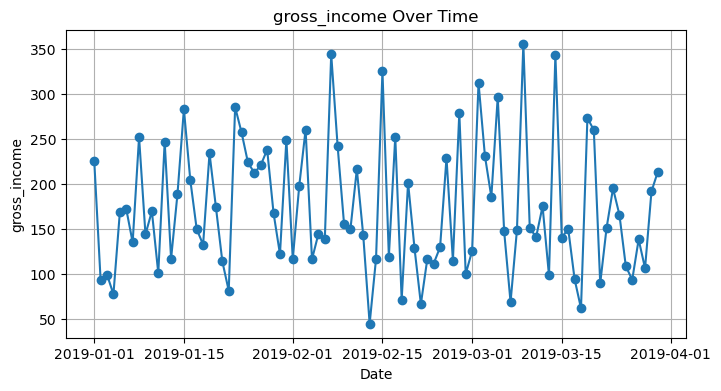

In [6]:
# Plot the total sales over time
plt.figure(figsize=(8, 4))
plt.plot(gross_income_by_date['date'], gross_income_by_date['gross_income'], marker='o')
plt.title('gross_income Over Time')
plt.xlabel('Date')
plt.ylabel('gross_income')
plt.grid(True)
plt.show()

### Next Steps in EDA
1- Seasonal Decomposition:
* Perform a seasonal decomposition to understand the trend, seasonality, and residual components.

2- Moving Average:
* Plot a moving average to smooth out short-term fluctuations and highlight longer-term trends.

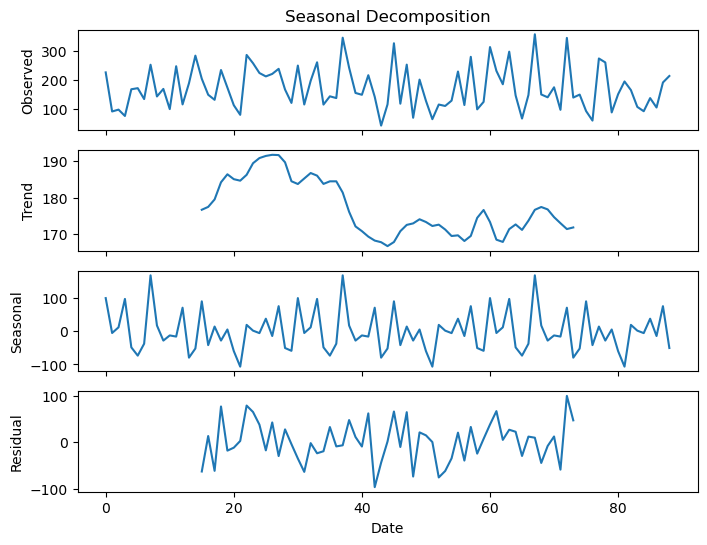

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(gross_income_by_date['gross_income'], model='additive', period=30)

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()

##### The seasonal decomposition plot shows the observed data, trend, seasonal component, and residuals. Here's a summary of the components:
- **Observed:** The original Gross income data.
- **Trend:** The overall direction of the data over time.
- **Seasonal:** Repeating patterns at a fixed period (monthly in this case).
- **Residual:** The remaining variations after removing the trend and seasonal components.

### 4. Feature engineering

1. Create Separate DataFrames for Each Branch:1. Create Separate DataFrames for Each Branch:

In [8]:
# Create separate DataFrames for each branch
branch_a_df = df1[df1['branch'] == 'A']
branch_b_df = df1[df1['branch'] == 'B']
branch_c_df = df1[df1['branch'] == 'C']


2. Aggregate Data for Each Branch:

In [9]:
# Function to aggregate data for a branch
def aggregate_branch_data(branch_df):
    return branch_df.groupby('date').agg({
        'unit_price': 'mean',
        'quantity': 'sum',
        'rating': 'mean',
        'day': 'first',
        'month': 'first',
        'year': 'first',
        'gross_income': 'sum'
    }).reset_index()

# Aggregate for each branch
branch_a_agg = aggregate_branch_data(branch_a_df)
branch_b_agg = aggregate_branch_data(branch_b_df)
branch_c_agg = aggregate_branch_data(branch_c_df)

# Add branch identifier
branch_a_agg['branch'] = 'A'
branch_b_agg['branch'] = 'B'
branch_c_agg['branch'] = 'C'


3. Concatenate Aggregated DataFrames:

In [10]:
# Concatenate the DataFrames
combined_df1 = pd.concat([branch_a_agg, branch_b_agg, branch_c_agg], ignore_index=True)

# Convert the 'date' column to datetime format and sort
combined_df1['date'] = pd.to_datetime(combined_df1['date'])
combined_df1 = combined_df1.sort_values(by='date').reset_index(drop=True)


In [40]:
combined_df1.to_csv('../Dataset/cleaned/combined_df1.csv', index=False)

4. One-Hot Encoding of Categorical Variables:


In [11]:
# One-hot encode the 'branch' column
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False)
branch_encoded = encoder.fit_transform(combined_df1[['branch']])

# Create a DataFrame with the one-hot encoded branch data
branch_encoded_df = pd.DataFrame(branch_encoded, columns=encoder.get_feature_names_out(['branch']))

# Concatenate the one-hot encoded columns to the original dataframe
combined_df_encoded1 = pd.concat([combined_df1.drop(columns=['branch']), branch_encoded_df], axis=1)


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
combined_df_encoded1.to_csv('../Dataset/cleaned/combined_df_encoded1.csv', index=False)

5. Shift Lag and Rolling Lag Moving Average:

In [12]:
# Create lagged versions of 'quantity' and 'unit_price'
combined_df_encoded1['quantity_lag1'] = combined_df_encoded1['quantity'].shift(1)
combined_df_encoded1['unit_price_lag1'] = combined_df_encoded1['unit_price'].shift(1)

# Create rolling averages of 'quantity' and 'unit_price' with a window of 7
combined_df_encoded1['quantity_roll7'] = combined_df_encoded1['quantity'].rolling(window=7).mean()
combined_df_encoded1['unit_price_roll7'] = combined_df_encoded1['unit_price'].rolling(window=7).mean()


6. Transform 'Day' Column into Sine and Cosine Components:

In [13]:
# Transform 'day' column into sine and cosine components
combined_df_encoded1['day_sin'] = np.sin(2 * np.pi * combined_df_encoded1['day'] / 31)
combined_df_encoded1['day_cos'] = np.cos(2 * np.pi * combined_df_encoded1['day'] / 31)


7. Drop Rows with NaN Values and Calculate Rows Lost:

In [14]:
# Drop rows with NaN values resulting from the lag and rolling operations
combined_df_encoded_dropped = combined_df_encoded1.dropna().reset_index(drop=True)


### Model Development 
#### Train Test Split


In [15]:
# Prepare the data
from sklearn.model_selection import train_test_split

# Prepare the data
features = combined_df_encoded_dropped.drop(columns=['date','gross_income'])
target = combined_df_encoded_dropped['gross_income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [16]:
X_train

,unit_price,quantity,rating,day,month,year,branch_B,branch_C,quantity_lag1,unit_price_lag1,quantity_roll7,unit_price_roll7,day_sin,day_cos
75,60.881667,45,6.750000,28,1,2019,1.0,0.0,31.0,49.596667,28.142857,49.688214,-0.571268,0.820763
178,50.842222,57,7.366667,4,3,2019,0.0,0.0,9.0,64.470000,35.285714,53.317032,0.724793,0.688967
38,54.814000,37,7.080000,16,1,2019,0.0,1.0,33.0,52.878000,27.000000,60.240905,-0.101168,-0.994869
136,65.080000,8,6.833333,18,2,2019,0.0,1.0,14.0,61.746667,20.428571,59.703844,-0.485302,-0.874347
60,60.219000,59,7.300000,23,1,2019,0.0,1.0,36.0,59.267143,22.857143,57.821211,-0.998717,-0.050649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,66.443333,22,7.633333,8,2,2019,0.0,1.0,30.0,47.918333,30.571429,53.771587,0.998717,-0.050649
14,39.053333,14,7.066667,7,1,2019,0.0,1.0,17.0,78.240000,17.428571,60.804595,0.988468,0.151428
92,67.882000,37,5.960000,3,2,2019,0.0,0.0,19.0,54.590000,27.000000,55.936714,0.571268,0.820763
179,19.240000,9,8.000000,4,3,2019,1.0,0.0,57.0,50.842222,29.142857,48.304175,0.724793,0.688967


#### Normalization

In [17]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()

In [18]:
X_train_norm = normalizer.fit_transform(X_train)

In [19]:
#Fit it to our training data
#Transforming our training and testing data

X_test_norm = normalizer.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)


#### Model 1: Linear Regression
- MSE (Mean Squared Error): Lower is better.
- RMSE (Root Mean Squared Error): Lower is better.
- MAE (Mean Absolute Error): Lower is better.
- R² Score: Higher is better.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the Linear Regressor
linear_model = LinearRegression()

# Train the Linear Regression model
linear_model.fit(X_train, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)

# Calculate evaluation metrics
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Print the results
print('Mean Squared Error (MSE):', linear_mse)
print('Root Mean Squared Error (RMSE):', linear_rmse)
print('Mean Absolute Error (MAE):', linear_mae)
print('R2 Score:', linear_r2)


Mean Squared Error (MSE): 88.57455315957584
Root Mean Squared Error (RMSE): 9.411405482688323
Mean Absolute Error (MAE): 7.297138905897743
R2 Score: 0.9512265726254268


 #### Model 2:  Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Calculate evaluation metrics
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_predictions)

# Print the results
print('Mean Absolute Error (MAE):', dt_mae)
print('Mean Squared Error (MSE):', dt_mse)
print('Root Mean Squared Error (RMSE):', dt_rmse)
print('R2 Score:', dt_r2)



Mean Absolute Error (MAE): 12.481322115384616
Mean Squared Error (MSE): 288.6163915348557
Root Mean Squared Error (RMSE): 16.98871365156455
R2 Score: 0.8410738738215715


### Model 3: Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Print the results
print('Mean Squared Error (MSE):', rf_mse)
print('Root Mean Squared Error (RMSE):', rf_rmse)
print('Mean Absolute Error (MAE):', rf_mae)
print('R2 Score:', rf_r2)


Mean Squared Error (MSE): 144.32145050217602
Root Mean Squared Error (RMSE): 12.01338630454278
Mean Absolute Error (MAE): 8.252875000000005
R2 Score: 0.9205296382135917


### Model 4: Ensemple Methods: Gradient Boosting Regressor

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)

# Calculate evaluation metrics
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Print the results
print('Mean Squared Error (MSE):', gb_mse)
print('Root Mean Squared Error (RMSE):', gb_rmse)
print('Mean Absolute Error (MAE):', gb_mae)
print('R2 Score:', gb_r2)


Mean Squared Error (MSE): 90.32362331273342
Root Mean Squared Error (RMSE): 9.503874121258836
Mean Absolute Error (MAE): 7.225210167585271
R2 Score: 0.9502634501139943


### Model 5: K-Nearest Neighbors Regressor

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_model.predict(X_test)

# Calculate evaluation metrics
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

# Print the results
print('Mean Squared Error (MSE):', knn_mse)
print('Root Mean Squared Error (RMSE):', knn_rmse)
print('Mean Absolute Error (MAE):', knn_mae)
print('R2 Score:', knn_r2)


Mean Squared Error (MSE): 303.49074478307693
Root Mean Squared Error (RMSE): 17.420985758075716
Mean Absolute Error (MAE): 13.916261538461539
R2 Score: 0.8328833364491859


### Model 6: CatBoost

In [25]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=False)

# Train the model
model.fit(X_train, y_train) 

# Make predictions
predictions = model.predict(X_test)

# Calculate evaluation metrics
catboost_mse = mean_squared_error(y_test, predictions)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mae = mean_absolute_error(y_test, predictions)
catboost_r2 = r2_score(y_test, predictions)

# Print the results
print('Mean Squared Error (MSE):', catboost_mse)
print('Root Mean Squared Error (RMSE):', catboost_rmse)
print('Mean Absolute Error (MAE):', catboost_mae)
print('R2 Score:', catboost_r2)


Mean Squared Error (MSE): 91.61417914562948
Root Mean Squared Error (RMSE): 9.571529613683984
Mean Absolute Error (MAE): 7.014850225820936
R2 Score: 0.9495528077348542


### Model 7: Ensemple Methods: LightGBM

In [26]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the LightGBM Regressor
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Train the LightGBM Regressor
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_predictions = lgb_model.predict(X_test)

# Calculate evaluation metrics
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

# Print the results
print('Mean Squared Error (MSE):', lgb_mse)
print('Root Mean Squared Error (RMSE):', lgb_rmse)
print('Mean Absolute Error (MAE):', lgb_mae)
print('R2 Score:', lgb_r2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 13
[LightGBM] [Info] Start training from score 56.899693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### Model 8: LSTM (Long Short-Term Memory) Networks

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and appropriate for model training

# Scale the data (LSTM models typically perform better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data into 3D format [samples, timesteps, features]
# Here we assume that each sample has 1 timestep
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test_scaled)

# Reshape predictions to be 1-dimensional
lstm_predictions = np.reshape(lstm_predictions, (lstm_predictions.shape[0],))

# Calculate evaluation metrics
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

# Print the results
print('Mean Squared Error (MSE):', lstm_mse)
print('Root Mean Squared Error (RMSE):', lstm_rmse)
print('Mean Absolute Error (MAE):', lstm_mae)
print('R2 Score:', lstm_r2)


2024-08-08 15:59:45.627107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
7/7 [==============================] - 6s 13ms/step - loss: 4577.1045
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 4570.3120
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 4561.5928
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 4549.1294
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 4529.8833
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 4500.3447
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 4456.9258
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 4390.6255
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 4300.0474
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 4186.6948
Epoch 11/100
7/7 [==============================] - 0s 6ms/step - loss: 4057.0352
Epoch 12/100
7/7 [==============================] - 0s 5ms/step - loss: 3922.1152
Epoch 13/100
7/7 [==

### Model 9: Ensemple Methods:XGBoost

In [28]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost Regressor
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Calculate evaluation metrics
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print the results
print('Mean Squared Error (MSE):', xgb_mse)
print('Root Mean Squared Error (RMSE):', xgb_rmse)
print('Mean Absolute Error (MAE):', xgb_mae)
print('R2 Score:', xgb_r2)



Mean Squared Error (MSE): 120.04651413900527
Root Mean Squared Error (RMSE): 10.956574014672892
Mean Absolute Error (MAE): 8.50514436985896
R2 Score: 0.9338965907241897


### Model 10:ARIMA  (AutoRegressive Integrated Moving Average)

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train ARIMA model
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_forecast = arima_model_fit.forecast(steps=len(y_test))
arima_predictions = arima_forecast.values

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_r2 = r2_score(y_test, arima_predictions)

# Print the results
print('Mean Squared Error (MSE):', arima_mse)
print('Root Mean Squared Error (RMSE):', arima_rmse)
print('Mean Absolute Error (MAE):', arima_mae)
print('R2 Score:', arima_r2)


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

Mean Squared Error (MSE): 1876.8896878576913
Root Mean Squared Error (RMSE): 43.32308493006576
Mean Absolute Error (MAE): 35.60626352713777
R2 Score: -0.03350612128846886


### All results

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize dictionary
results = {
    'Model': [],
    'RMSE': [],
    'MSE': [],
    'MAE': [],
    'R2 Score': []
}

# Add results for Linear Regression
results['Model'].append('Linear Regression')
results['RMSE'].append(linear_rmse)
results['MSE'].append(linear_mse)
results['MAE'].append(linear_mae)
results['R2 Score'].append(linear_r2)

# Add results for Decision Tree
results['Model'].append('Decision Tree')
results['RMSE'].append(dt_rmse)
results['MSE'].append(dt_mse)
results['MAE'].append(dt_mae)
results['R2 Score'].append(dt_r2)

# Add results for Random Forest
results['Model'].append('Random Forest')
results['RMSE'].append(rf_rmse)
results['MSE'].append(rf_mse)
results['MAE'].append(rf_mae)
results['R2 Score'].append(rf_r2)

# Add results for Gradient Boosting
results['Model'].append('Gradient Boosting')
results['RMSE'].append(gb_rmse)
results['MSE'].append(gb_mse)
results['MAE'].append(gb_mae)
results['R2 Score'].append(gb_r2)

# Add results for K-Nearest Neighbors
results['Model'].append('K-Nearest Neighbors')
results['RMSE'].append(knn_rmse)
results['MSE'].append(knn_mse)
results['MAE'].append(knn_mae)
results['R2 Score'].append(knn_r2)

# Add results for CatBoost
results['Model'].append('CatBoost')
results['RMSE'].append(catboost_rmse)
results['MSE'].append(catboost_mse)
results['MAE'].append(catboost_mae)
results['R2 Score'].append(catboost_r2)

# Add results for LightGBM
results['Model'].append('LightGBM')
results['RMSE'].append(lgb_rmse)
results['MSE'].append(lgb_mse)
results['MAE'].append(lgb_mae)
results['R2 Score'].append(lgb_r2)

# Add results for LSTM
results['Model'].append('LSTM')
results['RMSE'].append(lstm_rmse)
results['MSE'].append(lstm_mse)
results['MAE'].append(lstm_mae)
results['R2 Score'].append(lstm_r2)

# Add results for XGBoost
results['Model'].append('XGBoost')
results['RMSE'].append(xgb_rmse)
results['MSE'].append(xgb_mse)
results['MAE'].append(xgb_mae)
results['R2 Score'].append(xgb_r2)

# Add results for ARIMA
results['Model'].append('ARIMA')
results['RMSE'].append(arima_rmse)
results['MSE'].append(arima_mse)
results['MAE'].append(arima_mae)
results['R2 Score'].append(arima_r2)

# Convert dictionary to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                 Model       RMSE          MSE        MAE  R2 Score
0    Linear Regression   9.411405    88.574553   7.297139  0.951227
1        Decision Tree  16.988714   288.616392  12.481322  0.841074
2        Random Forest  12.013386   144.321451   8.252875  0.920530
3    Gradient Boosting   9.503874    90.323623   7.225210  0.950263
4  K-Nearest Neighbors  17.420986   303.490745  13.916262  0.832883
5             CatBoost   9.571530    91.614179   7.014850  0.949553
6             LightGBM  14.156236   200.399029  10.846185  0.889651
7                 LSTM  52.472057  2753.316786  39.786025 -0.516109
8              XGBoost  10.956574   120.046514   8.505144  0.933897
9                ARIMA  43.323085  1876.889688  35.606264 -0.033506


In [31]:
# Sort by RMSE to find the best model
sorted_by_rmse = results_df.sort_values(by='RMSE')
print("Models sorted by RMSE:")
print(sorted_by_rmse)

# Sort by R² Score to find the best model
sorted_by_r2 = results_df.sort_values(by='R2 Score', ascending=False)
print("Models sorted by R² Score:")
print(sorted_by_r2)

Models sorted by RMSE:
                 Model       RMSE          MSE        MAE  R2 Score
0    Linear Regression   9.411405    88.574553   7.297139  0.951227
3    Gradient Boosting   9.503874    90.323623   7.225210  0.950263
5             CatBoost   9.571530    91.614179   7.014850  0.949553
8              XGBoost  10.956574   120.046514   8.505144  0.933897
2        Random Forest  12.013386   144.321451   8.252875  0.920530
6             LightGBM  14.156236   200.399029  10.846185  0.889651
1        Decision Tree  16.988714   288.616392  12.481322  0.841074
4  K-Nearest Neighbors  17.420986   303.490745  13.916262  0.832883
9                ARIMA  43.323085  1876.889688  35.606264 -0.033506
7                 LSTM  52.472057  2753.316786  39.786025 -0.516109
Models sorted by R² Score:
                 Model       RMSE          MSE        MAE  R2 Score
0    Linear Regression   9.411405    88.574553   7.297139  0.951227
3    Gradient Boosting   9.503874    90.323623   7.225210  0.95026

#### Models sorted by RMSE:

    - Linear Regression: RMSE = 9.411405, R² Score = 0.951227
    - Gradient Boosting: RMSE = 9.503874, R² Score = 0.950263
    - CatBoost: RMSE = 9.571530, R² Score = 0.949553

####  Models sorted by R² Score:

    - Linear Regression: R² Score = 0.951227, RMSE = 9.411405
    - Gradient Boosting: R² Score = 0.950263, RMSE = 9.503874
    - CatBoost: R² Score = 0.949553, RMSE = 9.571530

####  Conclusion:
Linear Regression is the best model as it has the lowest RMSE (9.411405) and the highest R² Score (0.951227) among all models evaluated.

### Linear Regression Hyperparameter Tuning with Ridge Regression


In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# Initialize Ridge Regression model
ridge_model = Ridge()

# Set up Grid Search
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions with the best model
ridge_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Print results
print('Best Ridge Parameters:', best_params)
print('Ridge Mean Squared Error (MSE):', ridge_mse)
print('Ridge Root Mean Squared Error (RMSE):', ridge_rmse)
print('Ridge Mean Absolute Error (MAE):', ridge_mae)
print('Ridge R^2 Score:', ridge_r2)

Best Ridge Parameters: {'alpha': 100}
Ridge Mean Squared Error (MSE): 88.88722910216103
Ridge Root Mean Squared Error (RMSE): 9.42800239192593
Ridge Mean Absolute Error (MAE): 7.24356689595841
Ridge R^2 Score: 0.9510543981482947


In [33]:
# previous results before Hyperparameter Tuning with Ridge Regression
print('Mean Squared Error (MSE):', linear_mse)
print('Root Mean Squared Error (RMSE):', linear_rmse)
print('Mean Absolute Error (MAE):', linear_mae)
print('R2 Score:', linear_r2)

Mean Squared Error (MSE): 88.57455315957584
Root Mean Squared Error (RMSE): 9.411405482688323
Mean Absolute Error (MAE): 7.297138905897743
R2 Score: 0.9512265726254268


In [46]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the Ridge Regressor with the best alpha parameter
ridge_model = Ridge(alpha=100)

# Train the Ridge Regression model
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
ridge_predictions = ridge_model.predict(X_test)

# Calculate evaluation metrics
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Print the results
print('Mean Squared Error (MSE):', ridge_mse)
print('Root Mean Squared Error (RMSE):', ridge_rmse)
print('Mean Absolute Error (MAE):', ridge_mae)
print('R2 Score:', ridge_r2)


Mean Squared Error (MSE): 88.88722910216103
Root Mean Squared Error (RMSE): 9.42800239192593
Mean Absolute Error (MAE): 7.24356689595841
R2 Score: 0.9510543981482947


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the Linear Regressor
linear_model = LinearRegression()

# Train the Linear Regression model
linear_model.fit(X_train, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)

# Calculate evaluation metrics
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Print the results
print('Mean Squared Error (MSE):', linear_mse)
print('Root Mean Squared Error (RMSE):', linear_rmse)
print('Mean Absolute Error (MAE):', linear_mae)
print('R2 Score:', linear_r2)


Mean Squared Error (MSE): 88.57455315957584
Root Mean Squared Error (RMSE): 9.411405482688323
Mean Absolute Error (MAE): 7.297138905897743
R2 Score: 0.9512265726254268


### Forecast the next 1 day using the Linear Regression Model



In [34]:
combined_df_encoded_dropped.head()

,date,unit_price,quantity,rating,day,month,year,gross_income,branch_B,branch_C,quantity_lag1,unit_price_lag1,quantity_roll7,unit_price_roll7,day_sin,day_cos
0,2019-01-03,53.376667,19,7.500000,3,1,2019,44.6385,0.0,0.0,10.0,65.745000,21.142857,51.745357,0.571268,0.820763
1,2019-01-03,48.500000,3,8.400000,3,1,2019,5.9060,0.0,1.0,19.0,53.376667,16.285714,50.468214,0.571268,0.820763
2,2019-01-03,72.843333,15,8.533333,3,1,2019,48.4140,1.0,0.0,3.0,48.500000,15.000000,52.281071,0.571268,0.820763
3,2019-01-04,66.650000,9,9.700000,4,1,2019,29.9925,0.0,1.0,15.0,72.843333,13.428571,54.935000,0.724793,0.688967
4,2019-01-04,62.433333,8,4.866667,4,1,2019,24.3135,1.0,0.0,9.0,66.650000,13.571429,57.844762,0.724793,0.688967


In [37]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
# Assuming combined_df_encoded is already loaded
# List of features used in training (excluding 'total')
features = ['unit_price', 'quantity', 'rating', 'day', 'month', 'year',
            'branch_B', 'branch_C', 'quantity_lag1', 'unit_price_lag1',
            'quantity_roll7', 'unit_price_roll7', 'day_sin', 'day_cos']
# Verify the features in the combined_df_encoded
print('Features in the training data:' , features)
# Generate future dates
last_date = combined_df_encoded1['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]  # Predict for 7 days
# Create a DataFrame for the next 7 days
future_df = pd.DataFrame({'date': future_dates})
# Convert 'date' to datetime format if it's not already
future_df['date'] = pd.to_datetime(future_df['date'])
# Extract day, month, year, day_sin, and day_cos from the future dates
future_df['day'] = future_df['date'].dt.day
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 30)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 30)
# Use the mean of the existing data for other features (unit_price, quantity, rating, branch_B, branch_C)
mean_values = combined_df_encoded1[features].mean()
# Populate future_df with mean values where applicable
for feature in features:
    if feature not in future_df.columns:
        future_df[feature] = mean_values[feature]
# For lag and rolling features, use the last available values from combined_df_encoded
future_df['quantity_lag1'] = combined_df_encoded1['quantity'].iloc[-1]
future_df['unit_price_lag1'] = combined_df_encoded1['unit_price'].iloc[-1]
future_df['quantity_roll7'] = combined_df_encoded1['quantity'].rolling(window=7).mean().iloc[-1]
future_df['unit_price_roll7'] = combined_df_encoded1['unit_price'].rolling(window=7).mean().iloc[-1]
# Ensure that all columns have the same data types as in the training data
for feature in features:
    future_df[feature] = future_df[feature].astype(combined_df_encoded1[feature].dtype)
# Ensure the order of columns matches the training set, excluding 'date'
future_df_ordered = future_df[features]
# Verify the order of features and the number of features
print('Features in the ordered future data:', future_df_ordered.columns)
print('Number of features in the ordered future data:', future_df_ordered.shape[1])
print('Number of features expected by the model:', best_model.n_features_in_)
# Check if best_model is defined and trained
try:
    best_model
except NameError:
    print('The model is not defined. Please ensure it is trained and available in the environment.')
    raise
# Use the trained Ridge Regression model to make predictions for the next 7 days
try:
    future_predictions = best_model.predict(future_df_ordered)
except Exception as e:
    print('Error during prediction:', e)
    raise
# Add 'date' column back to future_df for displaying predictions
future_df['date'] = future_dates
# Add predictions back to the DataFrame
future_df['total_predictions'] = future_predictions
# Display the predictions
print(future_df[['date', 'total_predictions']])


Features in the training data: ['unit_price', 'quantity', 'rating', 'day', 'month', 'year', 'branch_B', 'branch_C', 'quantity_lag1', 'unit_price_lag1', 'quantity_roll7', 'unit_price_roll7', 'day_sin', 'day_cos']
Features in the ordered future data: Index(['unit_price', 'quantity', 'rating', 'day', 'month', 'year', 'branch_B',
       'branch_C', 'quantity_lag1', 'unit_price_lag1', 'quantity_roll7',
       'unit_price_roll7', 'day_sin', 'day_cos'],
      dtype='object')
Number of features in the ordered future data: 14
Number of features expected by the model: 14
        date  total_predictions
0 2019-03-31          54.234216
1 2019-04-01          53.965310
2 2019-04-02          54.070094
3 2019-04-03          54.194485
4 2019-04-04          54.332977
5 2019-04-05          54.479448
6 2019-04-06          54.627428


In [ ]:
gross_income_by_date

,date,gross_income,year,month,day
0,2019-01-01,225.9610,2019,1,1
1,2019-01-02,92.6430,2019,1,2
2,2019-01-03,98.9585,2019,1,3
3,2019-01-04,77.3185,2019,1,4
4,2019-01-05,168.4135,2019,1,5
...,...,...,...,...,...
84,2019-03-26,93.4530,2019,3,26
85,2019-03-27,138.2295,2019,3,27
86,2019-03-28,106.1620,2019,3,28
87,2019-03-29,191.5830,2019,3,29


### **Combine Historical and Future data and Visualize them** 

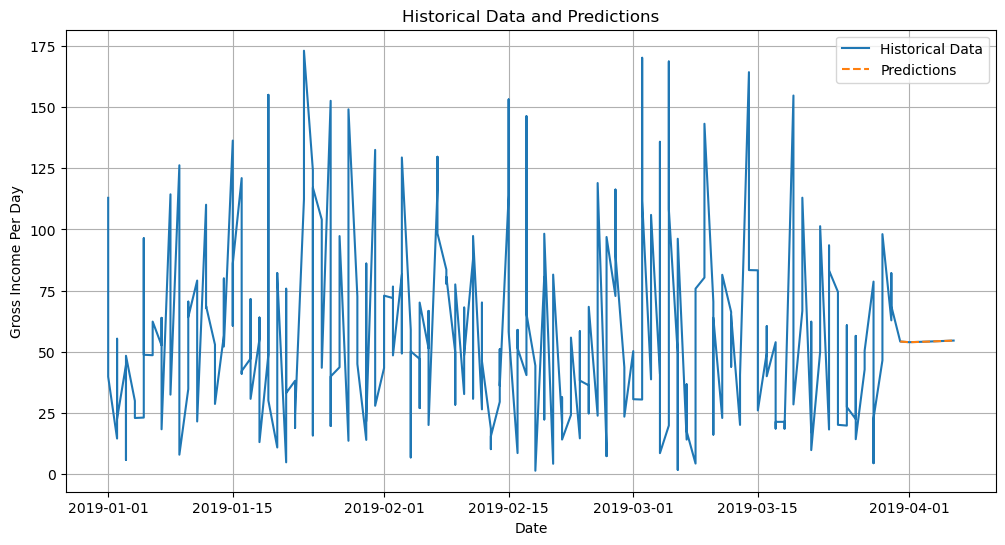

In [42]:
import matplotlib.pyplot as plt

# Combine historical data and future predictions
combined_df_encoded1['date'] = pd.to_datetime(combined_df_encoded1['date'])
predictions_df = future_df[['date', 'total_predictions']].rename(columns={'total_predictions': 'gross_income'})
combined_data = pd.concat([combined_df_encoded1[['date', 'gross_income']], predictions_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(12, 6))
plt.plot(combined_data['date'], combined_data['gross_income'], label='Historical Data')
plt.plot(predictions_df['date'], predictions_df['gross_income'], label='Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gross Income Per Day')
plt.title('Historical Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()